In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.backends import cudnn

In [ ]:
from option import get_option, parser
from trainer import Trainer
from utils import save_option
import data_loader
import models

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
#logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger(__name__)

import warnings
warnings.filterwarnings("ignore")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
seed = 87
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
from urlnet_utils import *

In [ ]:
min_word_freq = 5
max_len_words = 200
max_len_chars = 200
max_len_subwords = 20
delimit_mode = 1
dev_pct = 0.1

In [ ]:
urls, labels = read_data("../URLNet/train_10000.txt")

high_freq_words = None
if min_word_freq > 0:
    x1, word_reverse_dict = get_word_vocab(urls, max_len_words, min_word_freq) 
    high_freq_words = sorted(list(word_reverse_dict.values()))
    print("Number of words with freq >={}: {}".format(min_word_freq, len(high_freq_words)))

x, word_reverse_dict = get_word_vocab(urls, max_len_words)
word_x = get_words(x, word_reverse_dict, delimit_mode, urls)
ngramed_id_x, ngrams_dict, worded_id_x, words_dict = ngram_id_x(word_x, max_len_subwords, high_freq_words)
reverse_dict = {words_dict[i]:i for i in words_dict}
chars_dict = ngrams_dict
chared_id_x = char_id_x(urls, chars_dict, max_len_chars)
print("Overall Mal/Ben rate: {}/{}".format(np.sum(labels==1), np.sum(labels==0)))

########  shuffle & split  ######

shuffle_idx = np.random.permutation(np.arange(len(labels)))
train, test = prep_train_test(len(labels), dev_pct)
#y_train, y_test = to_categorical(labels[train], nb_classes=2), to_categorical(labels[test], nb_classes=2)
y_train, y_val = labels[train], labels[test]

x_train_char = ngramed_id_x[train]
x_val_char = ngramed_id_x[test]
x_train_word = pad_seq_in_word(worded_id_x[train], max_len_words)
x_val_word = pad_seq_in_word(worded_id_x[test], max_len_words)
x_train_char_seq = pad_seq_in_word(chared_id_x[train], max_len_chars)
x_val_char_seq = pad_seq_in_word(chared_id_x[test], max_len_chars)
print(x_train_word.shape, x_val_word.shape, x_train_char_seq.shape, x_val_char_seq.shape)

In [ ]:
# from pandarallel import pandarallel
# pandarallel.initialize(nb_workers=1)

if not os.path.isfile("word_mal_ratio.pkl"):
    df_tmp = pd.DataFrame({'token':word_x, "label":labels})
    word_mal_ratio = dict()

    for word in tqdm(words_dict):
        df_tmp['exist'] = df_tmp['token'].map(lambda x:word in x)
        cnt = len(df_tmp.query('exist == True & label == 0'))
        word_mal_ratio[word] = cnt / df_tmp.exist.sum()
    
    with open("word_mal_ratio.pkl", "wb") as f:
        pickle.dump(word_mal_ratio, f)
else:
    with open("word_mal_ratio.pkl", "rb") as f:
        word_mal_ratio = pickle.load(f)


tmp = [word_mal_ratio[i] for i in word_mal_ratio]
tmp = pd.DataFrame({'word_mal_ratio':tmp, 'word':[i for i in word_mal_ratio]})
tmp.plot(kind='hist')

In [ ]:
tmp1 = words_dict
tmp2 = ngrams_dict

In [ ]:
urls, labels = read_data("../URLNet/val_10000.txt")
x, word_reverse_dict = get_word_vocab(urls, max_len_words) 
word_x = get_words(x, word_reverse_dict, delimit_mode, urls) 
ngramed_id_x, worded_id_x = ngram_id_x_from_dict(word_x, max_len_subwords, ngrams_dict, words_dict) 
chared_id_x = char_id_x(urls, chars_dict, max_len_chars)
print("Number of testing urls: {}".format(len(labels)))

y_test = labels
x_test_char = ngramed_id_x
x_test_word = pad_seq_in_word(worded_id_x, max_len_words)
x_test_char_seq = pad_seq_in_word(chared_id_x, max_len_chars)
print(x_test_word.shape, x_test_char_seq.shape, x_test_char_seq.shape)

In [ ]:
assert tmp1 == words_dict
assert tmp2 == ngrams_dict

In [ ]:
urls, labels = read_data("../taipei/out.csv")#"../URLNet/test_10000.txt"
x, word_reverse_dict = get_word_vocab(urls, max_len_words) 
word_x = get_words(x, word_reverse_dict, delimit_mode, urls) 
ngramed_id_x, worded_id_x = ngram_id_x_from_dict(word_x, max_len_subwords, ngrams_dict, words_dict)
chared_id_x = char_id_x(urls, chars_dict, max_len_chars)
print("Number of testing urls: {}".format(len(labels)))

y_test2 = labels
x_test_char2 = ngramed_id_x
x_test_word2 = pad_seq_in_word(worded_id_x, max_len_words)
x_test_char_seq2 = pad_seq_in_word(chared_id_x, max_len_chars)
print(x_test_word2.shape, x_test_char_seq2.shape, x_test_char_seq2.shape)

In [ ]:
assert tmp1 == words_dict
assert tmp2 == ngrams_dict

In [ ]:
emb_dim = 32
l2_reg_lambda = 0.0
emb_mode = 2
filter_size = [3,4,5,6]
batch_size = 128
epochs = 5
lr = 1e-3

In [ ]:
from torch.utils.data import Dataset, DataLoader
class mydata(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

train_dataset = mydata(x_train_word, y_train)
val_dataset = mydata(x_val_word, y_val)
test_dataset1 = mydata(x_test_word, y_test)
test_dataset2 = mydata(x_test_word2, y_test2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)

In [ ]:
def accuracy_thresh_sum(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True):
    y_pred = F.sigmoid(y_pred)
    return ((y_pred>thresh)==y_true.byte()).float().sum().item()

def accuracy_thresh_score(y_pred, y_true, thresh:float=0.5):
    return ((y_pred>0.5).astype(int) == y_true).mean()

In [ ]:
def soft_cross_entropy(inp, target, size_average=True):
    if size_average:
        return torch.mean(torch.sum(-target * F.log_softmax(inp), dim=1))
    else:
        return torch.sum(torch.sum(-target * F.log_softmax(inp), dim=1))

class NegativeEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(NegativeEntropyLoss, self).__init__()

    def forward(self, x):
        b = F.softmax(x, dim=1) * F.log_softmax(x, dim=1)
        b = -1.0 * b.sum()
        return b

In [ ]:
model = models.WordCNN(
            word_ngram_vocab_size = len(words_dict)+1,
            emb_size=emb_dim,
            word_seq_len=max_len_words,
            l2_reg_lambda=l2_reg_lambda,
            kernel_sizes=filter_size).cuda()

print('paramters count', sum(p.numel() for p in model.parameters()))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
model

In [ ]:
def step(model, optimizer, loader, train=True, message=""):
    loss_total = 0
    all_logits = []
    all_labels = []
    
    model.train() if train else model.eval()
    mode = torch.enable_grad if train else torch.no_grad
    
    with mode():
        for (data, label) in tqdm(loader, desc=message):
            data, label = data.long().cuda(), label.float().cuda()
            logits = model(data).squeeze()
            loss = F.binary_cross_entropy_with_logits(logits, label, reduction="sum")
            if train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            loss_total += loss.item()
            all_labels.append(label.detach().cpu().numpy())
            all_logits.append(F.sigmoid(logits).detach().cpu().numpy())
            
            
    loss_total /= (len(loader)/batch_size)
    all_labels = np.hstack(all_labels)
    all_logits = np.hstack(all_logits)
    auc = roc_auc_score(all_labels, all_logits) if len(np.unique(all_labels)) > 1 else 0
    acc = accuracy_thresh_score(all_logits, all_labels)
    
    #logger.info(message)
    logger.info('Loss     : {}'.format(loss_total))
    logger.info('Accuracy : {}'.format(acc))
    logger.info('AUC      : {}'.format(auc))
    
    return {'loss':loss_total, 'acc':acc, 'auc':auc}

In [ ]:
# start straining

history = {'train':[], 'valid':[], 'test1':[], 'test2':[]}
for e in tqdm(range(10), desc="Epoch"):
    train_result =  step(model, optimizer, train_loader, train=True, message="Training :{}".format(e))
    valid_result = step(model, optimizer, val_loader, train=False, message="Validation :{}".format(e))
    test_result1 = step(model, optimizer, test_loader1, train=False, message="Test 1 :{}".format(e))
    test_result2 = step(model, optimizer, test_loader2, train=False, message="Test 2 :{}".format(e))
    
    history['train'].append(train_result)
    history['valid'].append(valid_result)
    history['test1'].append(test_result1)
    history['test2'].append(test_result2)

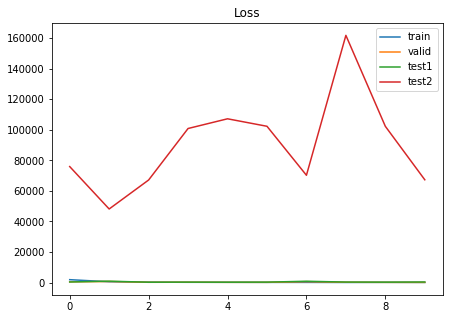

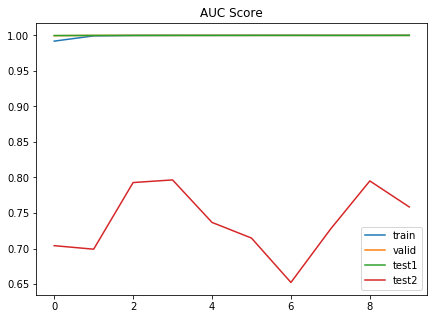

In [24]:
save = "baseline2"

train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
test1_loss = [l['loss'] for l in history['test1']]
test2_loss = [l['loss'] for l in history['test2']]

train_auc = [l['auc'] for l in history['train']]
valid_auc = [l['auc'] for l in history['valid']]
test1_auc = [l['auc'] for l in history['test1']]
test2_auc = [l['auc'] for l in history['test2']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.plot(test1_loss, label='test1')
plt.plot(test2_loss, label='test2')
plt.legend()
if save:
    path = os.path.join("output", save+'_loss.png')
    plt.savefig(path)
plt.show()

plt.figure(figsize=(7,5))
plt.title('AUC Score')
plt.plot(train_auc, label='train')
plt.plot(valid_auc, label='valid')
plt.plot(test1_auc, label='test1')
plt.plot(test2_auc, label='test2')
plt.legend()
if save:
    path = os.path.join("output", save+'_auc.png')
    plt.savefig(path)
plt.show()

# Adversarial training

In [25]:
UNKId = words_dict['<UNKNOWN>']
word_mal_ratio['<UNKNOWN>'] = 0.5
data = list(map(lambda x:words_dict.get(x, UNKId), word_mal_ratio.keys()))
label = list(map(lambda x:np.array([x, 1-x]), word_mal_ratio.values()))

emb_ratio_dataset = mydata(data, label)
emb_ratio_loader = DataLoader(emb_ratio_dataset, batch_size=batch_size, shuffle=True)

In [26]:
d, l = next(iter(emb_ratio_loader))
d.unsqueeze(1).shape

torch.Size([128, 1])

In [51]:
def emb_step(model, optimizer, train=False, iters=1):
    
    loader = emb_ratio_loader
    loss_total = 0
    _lambda = 0.1
    
    model.train() if train else model.eval()
    mode = torch.enable_grad if train else torch.no_grad
    with mode():
        for _ in range(iters):
            for (data, label) in loader:
            #for (data, label) in tqdm(loader, desc="emb bias"):
                data, label = data.long().unsqueeze(1).cuda(), label.float().cuda()
                logits = model(data)
                loss = soft_cross_entropy(logits, label, size_average=True) * _lambda
                if train:
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    optimizer.zero_grad()
                loss_total += loss.item()
                
    loss_total /= (len(loader)*iters/batch_size)
    return loss_total

In [56]:
def adv_step(model, optimizer, loader, train=True, message=""):
    loss_total = 0
    bias_loss_total = 0
    all_logits = []
    all_labels = []
    
    model.train() if train else model.eval()
    bias_model.train if train else bias_model.eval()
    mode = torch.enable_grad if train else torch.no_grad
    
    with mode():
        for (data, label) in tqdm(loader, desc=message):
            data, label = data.long().cuda(), label.float().cuda()
            logits = model(data).squeeze()
            loss = F.binary_cross_entropy_with_logits(logits, label, reduction="sum")
            if train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            loss_total += loss.item()
            all_labels.append(label.detach().cpu().numpy())
            all_logits.append(F.sigmoid(logits).detach().cpu().numpy())
            
#             ###adv step for each original batch
#             logits = bias_model(data).squeeze()
#             _lambda = 0.01
#             bias_loss = _lambda * soft_cross_entropy(logits)
#             if train:
#                 bias_loss.backward()
#                 bias__optimizer.step()
#                 bias__optimizer.zero_grad()
#             bias_loss_total += bias_loss.item()
#     bias_loss_total = bias_loss_total/(len(loader)/batch_size
    
    loss_total /= (len(loader)/batch_size)
    all_labels = np.hstack(all_labels)
    all_logits = np.hstack(all_logits)
    auc = roc_auc_score(all_labels, all_logits) if len(np.unique(all_labels)) > 1 else 0
    acc = accuracy_thresh_score(all_logits, all_labels)
    

    bias_loss_total = emb_step(bias_model, bias_optimizer, train, 3)
    logger.info('Loss     : {}'.format(loss_total))
    logger.info('Bias Loss: {}'.format(bias_loss_total))
    logger.info('Accuracy : {}'.format(acc))
    logger.info('AUC      : {}'.format(auc))
    
    return {'loss':loss_total, 'acc':acc, 'auc':auc, "bias":bias_loss_total}

In [57]:
adv_model = models.WordCNN(
            word_ngram_vocab_size = len(words_dict)+1,
            emb_size=emb_dim,
            word_seq_len=max_len_words,
            l2_reg_lambda=l2_reg_lambda,
            kernel_sizes=filter_size).cuda()
adv_optimizer = torch.optim.Adam(adv_model.parameters(), lr=1e-3)

bias_model = models.BiasPredictor(adv_model.word_emb, emb_dim).cuda()
bias_optimizer = torch.optim.Adam(bias_model.parameters(), lr=1e-4)

In [58]:
# start straining

history = {'train':[], 'valid':[], 'test1':[], 'test2':[]}
for e in tqdm(range(10), desc="Epoch"):
    train_result = adv_step(adv_model, adv_optimizer, train_loader, train=True, message="Training :{}".format(e))
    valid_result = adv_step(adv_model, adv_optimizer, val_loader, train=False, message="Validation :{}".format(e))
    test_result1 = adv_step(adv_model, adv_optimizer, test_loader1, train=False, message="Test 1 :{}".format(e))
    test_result2 = adv_step(adv_model, adv_optimizer, test_loader2, train=False, message="Test 2 :{}".format(e))
    
    history['train'].append(train_result)
    history['valid'].append(valid_result)
    history['test1'].append(test_result1)
    history['test2'].append(test_result2)

10/26/2019 15:02:10 - INFO - __main__ -   Loss     : 1965.4996161335582
10/26/2019 15:02:10 - INFO - __main__ -   Bias Loss: 89.8339655134413
10/26/2019 15:02:10 - INFO - __main__ -   Accuracy : 0.949510634293243
10/26/2019 15:02:10 - INFO - __main__ -   AUC      : 0.9909846541599434


10/26/2019 15:02:11 - INFO - __main__ -   Loss     : 460.784828392235
10/26/2019 15:02:11 - INFO - __main__ -   Bias Loss: 88.58572493659125
10/26/2019 15:02:11 - INFO - __main__ -   Accuracy : 0.9900465904277849
10/26/2019 15:02:11 - INFO - __main__ -   AUC      : 0.9996608179154217


10/26/2019 15:02:12 - INFO - __main__ -   Loss     : 391.2125813553973
10/26/2019 15:02:12 - INFO - __main__ -   Bias Loss: 88.73459392123752
10/26/2019 15:02:12 - INFO - __main__ -   Accuracy : 0.9923780487804879
10/26/2019 15:02:12 - INFO - __main__ -   AUC      : 0.9997981228621358


10/26/2019 15:06:15 - INFO - __main__ -   Loss     : 24204.678286321614
10/26/2019 15:06:15 - INFO - __main__ -   Bias Loss: 88.67041679664895
10/26/2019 15:06:15 - INFO - __main__ -   Accuracy : 0.4847847080503271
10/26/2019 15:06:15 - INFO - __main__ -   AUC      : 0.8166102861286981


10/26/2019 15:06:29 - INFO - __main__ -   Loss     : 416.85564982606934
10/26/2019 15:06:29 - INFO - __main__ -   Bias Loss: 87.82875103420682
10/26/2019 15:06:29 - INFO - __main__ -   Accuracy : 0.9914831545266328
10/26/2019 15:06:29 - INFO - __main__ -   AUC      : 0.9995016445121107


10/26/2019 15:06:30 - INFO - __main__ -   Loss     : 222.14853875701493
10/26/2019 15:06:30 - INFO - __main__ -   Bias Loss: 86.91133336667662
10/26/2019 15:06:30 - INFO - __main__ -   Accuracy : 0.9938585345192715
10/26/2019 15:06:30 - INFO - __main__ -   AUC      : 0.9998971141691565


10/26/2019 15:06:31 - INFO - __main__ -   Loss     : 238.38160778254996
10/26/2019 15:06:31 - INFO - __main__ -   Bias Loss: 86.89875814649794
10/26/2019 15:06:31 - INFO - __main__ -   Accuracy : 0.993140243902439
10/26/2019 15:06:31 - INFO - __main__ -   AUC      : 0.9998929615463266


10/26/2019 15:10:37 - INFO - __main__ -   Loss     : 54798.292057935236
10/26/2019 15:10:37 - INFO - __main__ -   Bias Loss: 87.03191870230215
10/26/2019 15:10:37 - INFO - __main__ -   Accuracy : 0.09386657642694439
10/26/2019 15:10:37 - INFO - __main__ -   AUC      : 0.846682632644903


10/26/2019 15:10:51 - INFO - __main__ -   Loss     : 225.25344355283556
10/26/2019 15:10:51 - INFO - __main__ -   Bias Loss: 86.60845947265625
10/26/2019 15:10:51 - INFO - __main__ -   Accuracy : 0.9954357236965933
10/26/2019 15:10:51 - INFO - __main__ -   AUC      : 0.9998167012475974


10/26/2019 15:10:52 - INFO - __main__ -   Loss     : 173.05883129222974
10/26/2019 15:10:52 - INFO - __main__ -   Bias Loss: 86.2601146697998
10/26/2019 15:10:52 - INFO - __main__ -   Accuracy : 0.9961880559085133
10/26/2019 15:10:52 - INFO - __main__ -   AUC      : 0.9999218929556424


10/26/2019 15:10:53 - INFO - __main__ -   Loss     : 164.11060302650057
10/26/2019 15:10:53 - INFO - __main__ -   Bias Loss: 86.24254996688278
10/26/2019 15:10:53 - INFO - __main__ -   Accuracy : 0.9965701219512195
10/26/2019 15:10:53 - INFO - __main__ -   AUC      : 0.9999546865704937


10/26/2019 15:14:56 - INFO - __main__ -   Loss     : 68936.4674849565
10/26/2019 15:14:56 - INFO - __main__ -   Bias Loss: 86.01218965318468
10/26/2019 15:14:56 - INFO - __main__ -   Accuracy : 0.09732250456665942
10/26/2019 15:14:56 - INFO - __main__ -   AUC      : 0.8263400293380349


10/26/2019 15:15:10 - INFO - __main__ -   Loss     : 133.1306662268562
10/26/2019 15:15:10 - INFO - __main__ -   Bias Loss: 86.0496378298159
10/26/2019 15:15:10 - INFO - __main__ -   Accuracy : 0.9974355354790138
10/26/2019 15:15:10 - INFO - __main__ -   AUC      : 0.9999169652920787


10/26/2019 15:15:11 - INFO - __main__ -   Loss     : 124.79943488095257
10/26/2019 15:15:11 - INFO - __main__ -   Bias Loss: 85.79470104641385
10/26/2019 15:15:11 - INFO - __main__ -   Accuracy : 0.9976704786107582
10/26/2019 15:15:11 - INFO - __main__ -   AUC      : 0.9999691162951045


10/26/2019 15:15:12 - INFO - __main__ -   Loss     : 154.7678668679806
10/26/2019 15:15:12 - INFO - __main__ -   Bias Loss: 85.61310916476779
10/26/2019 15:15:12 - INFO - __main__ -   Accuracy : 0.9977134146341463
10/26/2019 15:15:12 - INFO - __main__ -   AUC      : 0.9999664506339232


10/26/2019 15:19:14 - INFO - __main__ -   Loss     : 48082.89456747346
10/26/2019 15:19:14 - INFO - __main__ -   Bias Loss: 85.60014809502496
10/26/2019 15:19:14 - INFO - __main__ -   Accuracy : 0.12446866183930193
10/26/2019 15:19:14 - INFO - __main__ -   AUC      : 0.8348210945905574


10/26/2019 15:19:28 - INFO - __main__ -   Loss     : 95.85391874615398
10/26/2019 15:19:28 - INFO - __main__ -   Bias Loss: 85.48937741032353
10/26/2019 15:19:28 - INFO - __main__ -   Accuracy : 0.9981884057971014
10/26/2019 15:19:28 - INFO - __main__ -   AUC      : 0.9999629131417609


10/26/2019 15:19:29 - INFO - __main__ -   Loss     : 128.63750463563042
10/26/2019 15:19:29 - INFO - __main__ -   Bias Loss: 85.25674883524577
10/26/2019 15:19:29 - INFO - __main__ -   Accuracy : 0.9980940279542567
10/26/2019 15:19:29 - INFO - __main__ -   AUC      : 0.9999759394392094


10/26/2019 15:19:30 - INFO - __main__ -   Loss     : 126.93439471667132
10/26/2019 15:19:30 - INFO - __main__ -   Bias Loss: 85.254381886235
10/26/2019 15:19:30 - INFO - __main__ -   Accuracy : 0.9979039634146342
10/26/2019 15:19:30 - INFO - __main__ -   AUC      : 0.9999729862247174


10/26/2019 15:23:32 - INFO - __main__ -   Loss     : 73748.31559465878
10/26/2019 15:23:32 - INFO - __main__ -   Bias Loss: 85.144349416097
10/26/2019 15:23:32 - INFO - __main__ -   Accuracy : 0.08840902995751597
10/26/2019 15:23:32 - INFO - __main__ -   AUC      : 0.8442951022137566


10/26/2019 15:23:46 - INFO - __main__ -   Loss     : 106.19992211169085
10/26/2019 15:23:46 - INFO - __main__ -   Bias Loss: 85.1150254143609
10/26/2019 15:23:46 - INFO - __main__ -   Accuracy : 0.9981413514022209
10/26/2019 15:23:46 - INFO - __main__ -   AUC      : 0.9999376309751459


10/26/2019 15:23:47 - INFO - __main__ -   Loss     : 76.24782069470432
10/26/2019 15:23:47 - INFO - __main__ -   Bias Loss: 84.94394097504792
10/26/2019 15:23:47 - INFO - __main__ -   Accuracy : 0.9991529013130029
10/26/2019 15:23:47 - INFO - __main__ -   AUC      : 0.9999314094461045


10/26/2019 15:23:48 - INFO - __main__ -   Loss     : 118.03376081985671
10/26/2019 15:23:48 - INFO - __main__ -   Bias Loss: 84.98358458059805
10/26/2019 15:23:48 - INFO - __main__ -   Accuracy : 0.9979039634146342
10/26/2019 15:23:48 - INFO - __main__ -   AUC      : 0.9999584626896193


10/26/2019 15:27:51 - INFO - __main__ -   Loss     : 63879.380782064014
10/26/2019 15:27:51 - INFO - __main__ -   Bias Loss: 84.90904892815485
10/26/2019 15:27:51 - INFO - __main__ -   Accuracy : 0.10004235742066328
10/26/2019 15:27:51 - INFO - __main__ -   AUC      : 0.8594115868952172


10/26/2019 15:28:05 - INFO - __main__ -   Loss     : 58.70824208860095
10/26/2019 15:28:05 - INFO - __main__ -   Bias Loss: 84.8232782151964
10/26/2019 15:28:05 - INFO - __main__ -   Accuracy : 0.9988001129305477
10/26/2019 15:28:05 - INFO - __main__ -   AUC      : 0.9999855770868913


10/26/2019 15:28:06 - INFO - __main__ -   Loss     : 134.8725127074364
10/26/2019 15:28:06 - INFO - __main__ -   Bias Loss: 84.828694096318
10/26/2019 15:28:06 - INFO - __main__ -   Accuracy : 0.9976704786107582
10/26/2019 15:28:06 - INFO - __main__ -   AUC      : 0.9999531357733854


10/26/2019 15:28:07 - INFO - __main__ -   Loss     : 224.475314585174
10/26/2019 15:28:07 - INFO - __main__ -   Bias Loss: 84.76308872081616
10/26/2019 15:28:07 - INFO - __main__ -   Accuracy : 0.9961890243902439
10/26/2019 15:28:07 - INFO - __main__ -   AUC      : 0.9998859902494794


10/26/2019 15:32:14 - INFO - __main__ -   Loss     : 84532.21393951523
10/26/2019 15:32:14 - INFO - __main__ -   Bias Loss: 84.61389767682111
10/26/2019 15:32:14 - INFO - __main__ -   Accuracy : 0.09186898665626148
10/26/2019 15:32:14 - INFO - __main__ -   AUC      : 0.8685033734071058


10/26/2019 15:32:28 - INFO - __main__ -   Loss     : 79.74643419158026
10/26/2019 15:32:28 - INFO - __main__ -   Bias Loss: 84.5889259620949
10/26/2019 15:32:28 - INFO - __main__ -   Accuracy : 0.9985648409561453
10/26/2019 15:32:28 - INFO - __main__ -   AUC      : 0.9999689134633029


10/26/2019 15:32:28 - INFO - __main__ -   Loss     : 143.79667423222517
10/26/2019 15:32:28 - INFO - __main__ -   Bias Loss: 84.51608982792607
10/26/2019 15:32:28 - INFO - __main__ -   Accuracy : 0.9966116052520119
10/26/2019 15:32:28 - INFO - __main__ -   AUC      : 0.9999736052056998


10/26/2019 15:32:29 - INFO - __main__ -   Loss     : 245.43059632545564
10/26/2019 15:32:29 - INFO - __main__ -   Bias Loss: 84.40921303077981
10/26/2019 15:32:29 - INFO - __main__ -   Accuracy : 0.9961890243902439
10/26/2019 15:32:29 - INFO - __main__ -   AUC      : 0.9999163444378346


10/26/2019 15:36:31 - INFO - __main__ -   Loss     : 65005.296107817994
10/26/2019 15:36:31 - INFO - __main__ -   Bias Loss: 84.64621367277923
10/26/2019 15:36:31 - INFO - __main__ -   Accuracy : 0.08250086038510722
10/26/2019 15:36:31 - INFO - __main__ -   AUC      : 0.8654292726871962


10/26/2019 15:36:45 - INFO - __main__ -   Loss     : 45.34982111442547
10/26/2019 15:36:45 - INFO - __main__ -   Bias Loss: 84.51313018798828
10/26/2019 15:36:45 - INFO - __main__ -   Accuracy : 0.9989883305100696
10/26/2019 15:36:45 - INFO - __main__ -   AUC      : 0.9999946528499912


10/26/2019 15:36:46 - INFO - __main__ -   Loss     : 83.37795935671878
10/26/2019 15:36:46 - INFO - __main__ -   Bias Loss: 84.22646805092141
10/26/2019 15:36:46 - INFO - __main__ -   Accuracy : 0.9985175772977551
10/26/2019 15:36:46 - INFO - __main__ -   AUC      : 0.9999766576649047


10/26/2019 15:36:47 - INFO - __main__ -   Loss     : 202.78901905584627
10/26/2019 15:36:47 - INFO - __main__ -   Bias Loss: 84.29369799296062
10/26/2019 15:36:47 - INFO - __main__ -   Accuracy : 0.9975228658536586
10/26/2019 15:36:47 - INFO - __main__ -   AUC      : 0.9998599931216537


10/26/2019 15:40:48 - INFO - __main__ -   Loss     : 72947.25213992943
10/26/2019 15:40:48 - INFO - __main__ -   Bias Loss: 84.45269471627695
10/26/2019 15:40:48 - INFO - __main__ -   Accuracy : 0.09261772312749698
10/26/2019 15:40:48 - INFO - __main__ -   AUC      : 0.8439705224283337


10/26/2019 15:41:02 - INFO - __main__ -   Loss     : 92.85446478891419
10/26/2019 15:41:02 - INFO - __main__ -   Bias Loss: 84.13091850280762
10/26/2019 15:41:02 - INFO - __main__ -   Accuracy : 0.9983766233766234
10/26/2019 15:41:02 - INFO - __main__ -   AUC      : 0.9999636460223627


10/26/2019 15:41:03 - INFO - __main__ -   Loss     : 122.07870981016674
10/26/2019 15:41:03 - INFO - __main__ -   Bias Loss: 83.99728308783637
10/26/2019 15:41:03 - INFO - __main__ -   Accuracy : 0.9978822532825075
10/26/2019 15:41:03 - INFO - __main__ -   AUC      : 0.9999721687543094


10/26/2019 15:41:04 - INFO - __main__ -   Loss     : 279.50283885765367
10/26/2019 15:41:04 - INFO - __main__ -   Bias Loss: 84.05830030088072
10/26/2019 15:41:04 - INFO - __main__ -   Accuracy : 0.9942835365853658
10/26/2019 15:41:04 - INFO - __main__ -   AUC      : 0.9999300691785025


10/26/2019 15:45:06 - INFO - __main__ -   Loss     : 51766.930535693056
10/26/2019 15:45:06 - INFO - __main__ -   Bias Loss: 84.11661084493001
10/26/2019 15:45:06 - INFO - __main__ -   Accuracy : 0.18311987725556142
10/26/2019 15:45:06 - INFO - __main__ -   AUC      : 0.8140271113904956


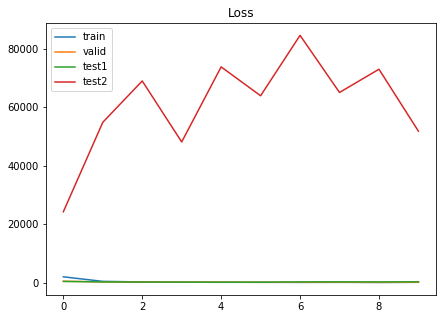

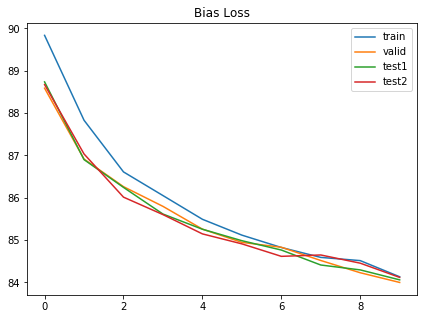

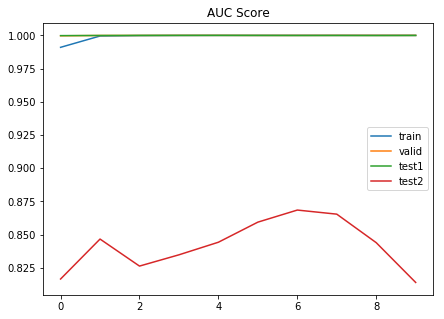

In [59]:
save = "adv"

train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
test1_loss = [l['loss'] for l in history['test1']]
test2_loss = [l['loss'] for l in history['test2']]

train_bloss = [l['bias'] for l in history['train']]
valid_bloss = [l['bias'] for l in history['valid']]
test1_bloss = [l['bias'] for l in history['test1']]
test2_bloss = [l['bias'] for l in history['test2']]

train_auc = [l['auc'] for l in history['train']]
valid_auc = [l['auc'] for l in history['valid']]
test1_auc = [l['auc'] for l in history['test1']]
test2_auc = [l['auc'] for l in history['test2']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.plot(test1_loss, label='test1')
plt.plot(test2_loss, label='test2')
plt.legend()
if save:
    path = os.path.join("output", save+'_loss.png')
    plt.savefig(path)
plt.show()


plt.figure(figsize=(7,5))
plt.title('Bias Loss')
plt.plot(train_bloss, label='train')
plt.plot(valid_bloss, label='valid')
plt.plot(test1_bloss, label='test1')
plt.plot(test2_bloss, label='test2')
plt.legend()
if save:
    path = os.path.join("output", save+'_bias_loss.png')
    plt.savefig(path)
plt.show()


plt.figure(figsize=(7,5))
plt.title('AUC Score')
plt.plot(train_auc, label='train')
plt.plot(valid_auc, label='valid')
plt.plot(test1_auc, label='test1')
plt.plot(test2_auc, label='test2')
plt.legend()
if save:
    path = os.path.join("output", save+'_auc.png')
    plt.savefig(path)
plt.show()